# HFO Detection Benchmark for SickKids Dataset

Running different HFO detectors implemented via `mne-hfo` to benchmark analysis.%

In [1]:
%load_ext lab_black

In [2]:
import os
from pathlib import Path
from mne_bids import (
    read_raw_bids,
    BIDSPath,
    get_entity_vals,
    get_datatypes,
    make_report,
)
from mne_hfo import HilbertDetector, LineLengthDetector, RMSDetector
from mne_hfo.io import write_annotations
from mne_hfo.posthoc import compute_chs_hfo_rates, match_detected_annotations
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import seaborn as sns
from sklearn.metrics import cohen_kappa_score, mutual_info_score

# Dataset Paths

Here, let's obtain all the different datasets we want to run.

In [35]:
reference = "average"
l_freq = 80
h_freq = 250

fpaths = {
    "extraoperative": [],
    "preresection": [],
    "intraresection": [],
    "postresection": [],
}
# change this
bids_root = Path("C:/Users/patri/Johns Hopkins/Adam Li - sickkids")
bids_root = Path("/home/adam2392/hdd3/sickkids/")

deriv_root = bids_root / "derivatives"
deriv_path = deriv_root / "hfo" / reference
figure_dir = deriv_root / "figures" / "hfo" / reference

tasks = {
    "extraoperative": ["interictalawake", "interictalasleep"],
    "preresection": ["pre"],
    "intraresection": ["ictal"],
    "postresection": ["post"],
}

subjects = get_entity_vals(bids_root, "subject", ignore_subjects=["E6"])
subjects = ["E6"]

for subjectID in subjects:
    for sessionID in fpaths.keys():
        for task in tasks[sessionID]:
            bids_paths = BIDSPath(
                subject=subjectID,
                session=sessionID,
                datatype="ieeg",
                suffix="ieeg",
                extension=".vhdr",
                task=task,
                root=bids_root,
            )
            #         if sessionID == 'extraoperative':
            #             bids_paths.update(task='')
            fpaths[sessionID].extend(bids_paths.match())

In [36]:
datasets = fpaths.values()

print(f"About to run {len(np.hstack(datasets))} for datasets in {fpaths.keys()}")

About to run 2 for datasets in dict_keys(['extraoperative', 'preresection', 'intraresection', 'postresection'])


<ipython-input-36-81a263d2465d>:3: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  print(f"About to run {len(np.hstack(datasets))} for datasets in {fpaths.keys()}")


# Define Detectors

Here, we define different detectors, such as:

- Line Length Detector
- RMS detector
- Hilbert Detector



In [37]:
kwargs = {
    "filter_band": (l_freq, h_freq),
    "threshold": 3,
    "band_method": "log",
    "hfo_name": "ripple",
    "n_jobs": 1,
}

verbose = False
hil_detector = HilbertDetector(**kwargs)

rms_kwargs = {
    "threshold": 3,
    "win_size": 100,
    "overlap": 0.25,
}
rms_detector = RMSDetector(**rms_kwargs)

ll_kwargs = {
    "threshold": 3,
    "win_size": 100,
    "overlap": 0.25,
}
ll_detector = LineLengthDetector(**ll_kwargs)

detectors = {"linelength": ll_detector, "rms": rms_detector, "hilbert": hil_detector}

In [38]:
def plot_and_save(df, fpath, outpath, name):
    # compute HFO rate per hour
    ch_dict = compute_chs_hfo_rates(df, "h", verbose=False)

    # check which channels were resected
    channels_path = fpath.copy().update(extension=".tsv", suffix="channels")
    channel_df = pd.read_csv(channels_path, sep="\t")
    channel_df = channel_df[channel_df["name"].isin(raw.ch_names)].reset_index()
    resected = channel_df[channel_df["description"] == "resected"]
    resected_chnames = list(resected["name"])
    chnames = ch_dict.keys()
    resected_idxs = [
        ind for ind, chname in enumerate(chnames) if chname in resected_chnames
    ]
    xdat = ch_dict.keys()
    ydat = ch_dict.values()

    # make the plot
    sns.set_context("paper", font_scale=1.5)
    fig, ax = plt.subplots(
        figsize=(14, 6),
        #                      dpi=80,
        #         facecolor="w",
        #         edgecolor="k",
    )
    barlist = ax.bar(xdat, ydat)
    plt.xticks(
        rotation=90,
        #                fontsize=24
    )
    #     plt.yticks(fontsize=16)
    ax.set_xlabel(
        "Channels",
        #                fontsize=24
    )
    ax.set_ylabel(
        "HFOs per hour",
        #                fontsize=24
    )
    ax.set_title(
        f"{fpath.subject} during {fpath.session} HFOs \n (Computed with {name})",
        #               fontsize=36
    )
    print(len(ax.get_xticklabels()))
    [ax.get_xticklabels()[idx].set_color("#DC143C") for idx in resected_idxs]
    [barlist[idx].set_color("#DC143C") for idx in resected_idxs]
    os.makedirs(outpath.parent, exist_ok=True)

    fig.tight_layout()
    plt.savefig(str(outpath))
    # save the figure

In [39]:
overwrite = False

Extracting parameters from /home/adam2392/hdd3/sickkids/sub-E6/ses-preresection/ieeg/sub-E6_ses-preresection_task-pre_acq-ecog_run-01_ieeg.vhdr...
Setting channel info structure...
Reading channel info from /home/adam2392/hdd3/sickkids/sub-E6/ses-preresection/ieeg/sub-E6_ses-preresection_task-pre_acq-ecog_run-01_channels.tsv.
Reading electrode coords from /home/adam2392/hdd3/sickkids/sub-E6/ses-preresection/ieeg/sub-E6_ses-preresection_acq-ecog_space-fs_electrodes.tsv.
Applying average reference...
Reading 0 ... 3704063  =      0.000 ...  1807.583 secs...


<ipython-input-40-ec59ed316154>:24: RuntimeWarning: Did not find any events.tsv associated with sub-E6_ses-preresection_task-pre_acq-ecog_run-01.

The search_str was "/home/adam2392/hdd3/sickkids/sub-E6/**/sub-E6_ses-preresection*events.tsv"
  raw = read_raw_bids(fpath, verbose=verbose)
<ipython-input-40-ec59ed316154>:24: RuntimeWarning: Defaulting coordinate frame to unknown from coordinate system input Other
  raw = read_raw_bids(fpath, verbose=verbose)
<ipython-input-40-ec59ed316154>:24: RuntimeWarning: There are channels without locations (n/a) that are not marked as bad: ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'C22', 'C23', 'C24', 'C25', 'C26', 'C27', 'C28', 'C29', 'C30', 'C31', 'C32', 'C33', 'C34', 'C35', 'C36', 'C37', 'C38', 'C39', 'C40', 'C41', 'C42', 'C43', 'C44', 'C45', 'C46', 'C47', 'C48', 'C49', 'C50', 'C51', 'C52', 'C53', 'C54', 'C55', 'C56', 'C57', 'C58', 'C59', 'C60', 'C61', 'C62'

ECoG channel type selected for re-referencing
Applying average reference.
Applying a custom ECoG reference.


100%|██████████| 72/72 [00:15<00:00,  4.80it/s]


72
Extracting parameters from /home/adam2392/hdd3/sickkids/sub-E6/ses-postresection/ieeg/sub-E6_ses-postresection_task-post_acq-ecog_run-01_ieeg.vhdr...
Setting channel info structure...
Reading channel info from /home/adam2392/hdd3/sickkids/sub-E6/ses-postresection/ieeg/sub-E6_ses-postresection_task-post_acq-ecog_run-01_channels.tsv.
Reading electrode coords from /home/adam2392/hdd3/sickkids/sub-E6/ses-postresection/ieeg/sub-E6_ses-postresection_acq-ecog_space-fs_electrodes.tsv.
Applying average reference...
Reading 0 ... 424063  =      0.000 ...   206.943 secs...


<ipython-input-40-ec59ed316154>:24: RuntimeWarning: Did not find any events.tsv associated with sub-E6_ses-postresection_task-post_acq-ecog_run-01.

The search_str was "/home/adam2392/hdd3/sickkids/sub-E6/**/sub-E6_ses-postresection*events.tsv"
  raw = read_raw_bids(fpath, verbose=verbose)
<ipython-input-40-ec59ed316154>:24: RuntimeWarning: Defaulting coordinate frame to unknown from coordinate system input Other
  raw = read_raw_bids(fpath, verbose=verbose)
<ipython-input-40-ec59ed316154>:24: RuntimeWarning: There are channels without locations (n/a) that are not marked as bad: ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'C16', 'C21', 'C22', 'C23', 'C30', 'C31', 'C32', 'C39', 'C40', 'C41', 'C42', 'C43', 'C44', 'C45', 'C46', 'C47', 'C48', 'C50', 'C51', 'C55', 'C56', 'C57', 'C58', 'C59', 'C60', 'C61', 'C62', 'C63', 'C64', 'C83', 'C84', 'C85', 'C86', 'C87', 'C88', 'C89', 'C90', 'C91', 'C92', 'C93', 'C94', 'C95', 'C96', 'C97', 'C98', 'C99', 'C

ECoG channel type selected for re-referencing
Applying average reference.
Applying a custom ECoG reference.


100%|██████████| 35/35 [00:00<00:00, 8906.18it/s]


35
Extracting parameters from /home/adam2392/hdd3/sickkids/sub-E6/ses-preresection/ieeg/sub-E6_ses-preresection_task-pre_acq-ecog_run-01_ieeg.vhdr...
Setting channel info structure...
Reading channel info from /home/adam2392/hdd3/sickkids/sub-E6/ses-preresection/ieeg/sub-E6_ses-preresection_task-pre_acq-ecog_run-01_channels.tsv.
Reading electrode coords from /home/adam2392/hdd3/sickkids/sub-E6/ses-preresection/ieeg/sub-E6_ses-preresection_acq-ecog_space-fs_electrodes.tsv.
Applying average reference...
Reading 0 ... 3704063  =      0.000 ...  1807.583 secs...


<ipython-input-40-ec59ed316154>:24: RuntimeWarning: Did not find any events.tsv associated with sub-E6_ses-preresection_task-pre_acq-ecog_run-01.

The search_str was "/home/adam2392/hdd3/sickkids/sub-E6/**/sub-E6_ses-preresection*events.tsv"
  raw = read_raw_bids(fpath, verbose=verbose)
<ipython-input-40-ec59ed316154>:24: RuntimeWarning: Defaulting coordinate frame to unknown from coordinate system input Other
  raw = read_raw_bids(fpath, verbose=verbose)
<ipython-input-40-ec59ed316154>:24: RuntimeWarning: There are channels without locations (n/a) that are not marked as bad: ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'C22', 'C23', 'C24', 'C25', 'C26', 'C27', 'C28', 'C29', 'C30', 'C31', 'C32', 'C33', 'C34', 'C35', 'C36', 'C37', 'C38', 'C39', 'C40', 'C41', 'C42', 'C43', 'C44', 'C45', 'C46', 'C47', 'C48', 'C49', 'C50', 'C51', 'C52', 'C53', 'C54', 'C55', 'C56', 'C57', 'C58', 'C59', 'C60', 'C61', 'C62'

ECoG channel type selected for re-referencing
Applying average reference.
Applying a custom ECoG reference.


100%|██████████| 72/72 [00:11<00:00,  6.32it/s]


72
Extracting parameters from /home/adam2392/hdd3/sickkids/sub-E6/ses-postresection/ieeg/sub-E6_ses-postresection_task-post_acq-ecog_run-01_ieeg.vhdr...
Setting channel info structure...
Reading channel info from /home/adam2392/hdd3/sickkids/sub-E6/ses-postresection/ieeg/sub-E6_ses-postresection_task-post_acq-ecog_run-01_channels.tsv.
Reading electrode coords from /home/adam2392/hdd3/sickkids/sub-E6/ses-postresection/ieeg/sub-E6_ses-postresection_acq-ecog_space-fs_electrodes.tsv.
Applying average reference...
Reading 0 ... 424063  =      0.000 ...   206.943 secs...


<ipython-input-40-ec59ed316154>:24: RuntimeWarning: Did not find any events.tsv associated with sub-E6_ses-postresection_task-post_acq-ecog_run-01.

The search_str was "/home/adam2392/hdd3/sickkids/sub-E6/**/sub-E6_ses-postresection*events.tsv"
  raw = read_raw_bids(fpath, verbose=verbose)
<ipython-input-40-ec59ed316154>:24: RuntimeWarning: Defaulting coordinate frame to unknown from coordinate system input Other
  raw = read_raw_bids(fpath, verbose=verbose)
<ipython-input-40-ec59ed316154>:24: RuntimeWarning: There are channels without locations (n/a) that are not marked as bad: ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'C16', 'C21', 'C22', 'C23', 'C30', 'C31', 'C32', 'C39', 'C40', 'C41', 'C42', 'C43', 'C44', 'C45', 'C46', 'C47', 'C48', 'C50', 'C51', 'C55', 'C56', 'C57', 'C58', 'C59', 'C60', 'C61', 'C62', 'C63', 'C64', 'C83', 'C84', 'C85', 'C86', 'C87', 'C88', 'C89', 'C90', 'C91', 'C92', 'C93', 'C94', 'C95', 'C96', 'C97', 'C98', 'C99', 'C

ECoG channel type selected for re-referencing
Applying average reference.
Applying a custom ECoG reference.


100%|██████████| 35/35 [00:00<00:00, 11691.67it/s]


35
Extracting parameters from /home/adam2392/hdd3/sickkids/sub-E6/ses-preresection/ieeg/sub-E6_ses-preresection_task-pre_acq-ecog_run-01_ieeg.vhdr...
Setting channel info structure...
Reading channel info from /home/adam2392/hdd3/sickkids/sub-E6/ses-preresection/ieeg/sub-E6_ses-preresection_task-pre_acq-ecog_run-01_channels.tsv.
Reading electrode coords from /home/adam2392/hdd3/sickkids/sub-E6/ses-preresection/ieeg/sub-E6_ses-preresection_acq-ecog_space-fs_electrodes.tsv.
Applying average reference...
Reading 0 ... 3704063  =      0.000 ...  1807.583 secs...


<ipython-input-40-ec59ed316154>:24: RuntimeWarning: Did not find any events.tsv associated with sub-E6_ses-preresection_task-pre_acq-ecog_run-01.

The search_str was "/home/adam2392/hdd3/sickkids/sub-E6/**/sub-E6_ses-preresection*events.tsv"
  raw = read_raw_bids(fpath, verbose=verbose)
<ipython-input-40-ec59ed316154>:24: RuntimeWarning: Defaulting coordinate frame to unknown from coordinate system input Other
  raw = read_raw_bids(fpath, verbose=verbose)
<ipython-input-40-ec59ed316154>:24: RuntimeWarning: There are channels without locations (n/a) that are not marked as bad: ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'C22', 'C23', 'C24', 'C25', 'C26', 'C27', 'C28', 'C29', 'C30', 'C31', 'C32', 'C33', 'C34', 'C35', 'C36', 'C37', 'C38', 'C39', 'C40', 'C41', 'C42', 'C43', 'C44', 'C45', 'C46', 'C47', 'C48', 'C49', 'C50', 'C51', 'C52', 'C53', 'C54', 'C55', 'C56', 'C57', 'C58', 'C59', 'C60', 'C61', 'C62'

ECoG channel type selected for re-referencing
Applying average reference.
Applying a custom ECoG reference.


MemoryError: Unable to allocate 121. GiB for an array with shape (72, 61, 3704064) and data type float64

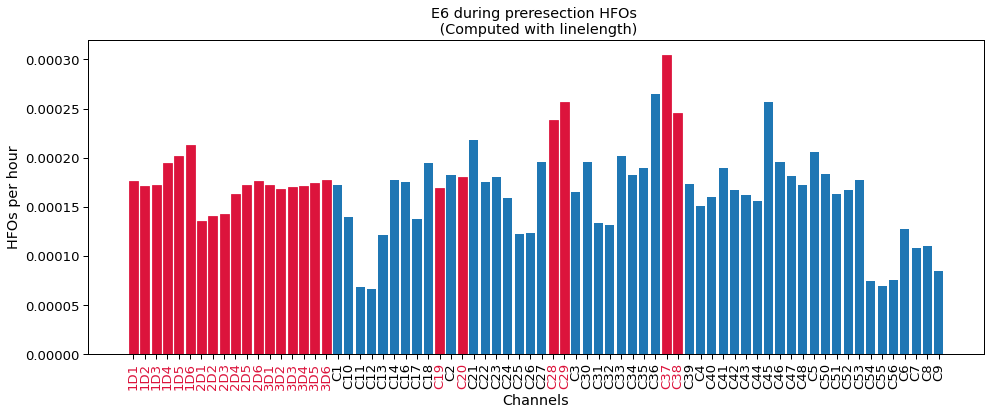

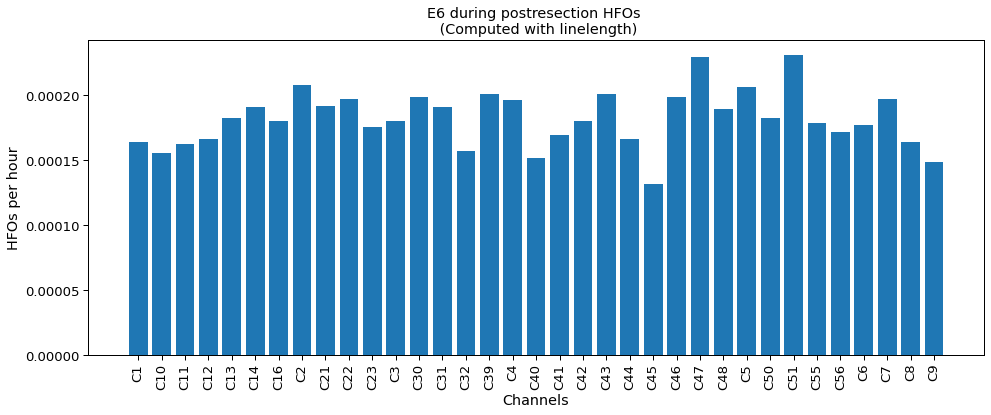

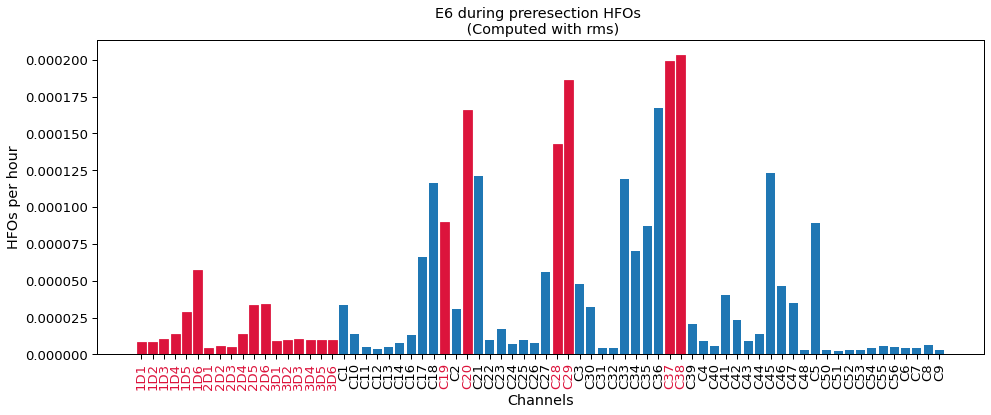

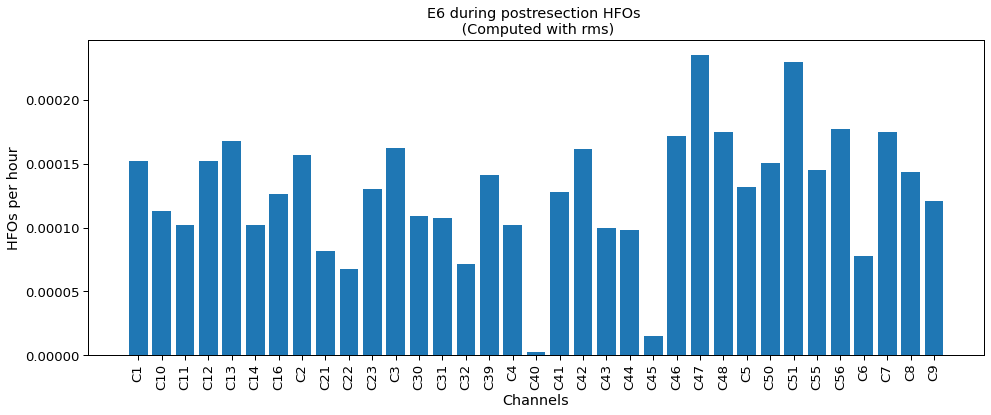

In [40]:
for name, detector in detectors.items():
    for session, filepaths in fpaths.items():
        for fpath in filepaths:
            outname = fpath.basename.replace(".vhdr", ".png")
            subject = fpath.subject
            session = fpath.session

            # write out the resulting annotations dataframe
            annot_fname = BIDSPath(
                root=deriv_path,
                extension=".tsv",
                datatype="ieeg",
                check=False,
                suffix="desc-hfo_ieeg",
                **fpath.entities,
            )
            annot_fname.update(processing=name)
            intended_for = fpath.copy().update(root=None).fpath
            annot_fname.fpath.parent.mkdir(exist_ok=True, parents=True)

            if annot_fname.fpath.exists() and not overwrite:
                continue

            raw = read_raw_bids(fpath, verbose=verbose)
            raw = raw.drop_channels(raw.info["bads"])
            raw = raw.pick_types(ecog=True, seeg=True)

            if reference == "average":
                print("Applying average reference...")
                raw.load_data()
                raw = raw.set_eeg_reference(reference)

            # run HFO detection
            detector.fit(raw)

            # extract the resulting annotations dataframe
            df = detector.hfo_df

            # write annots.tsv file
            write_annotations(
                df,
                annot_fname,
                intended_for=intended_for,
                root=bids_root,
                description=f"{name}hfo",
            )

            outdir = figure_dir / name / f"sub-{subject}" / f"ses-{session}"
            outpath = outdir / outname
            outpath
            plot_and_save(df, fpath, outpath, name)

#             break
#         break
#     break